# One step univariate model - ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA times series forecasting model
- implement a simple ARIMA model the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from common.utils import load_data, mape

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

demo = True

Load the data from csv into a Pandas dataframe

In [2]:
energy = load_data()[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


Plot all available load data (January 2012 to Dec 2014)

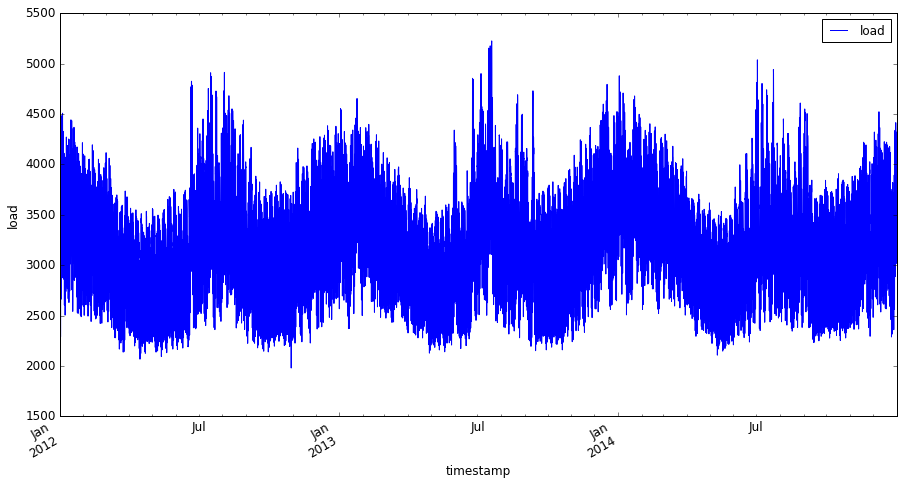

In [3]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Plot first week of July 2014

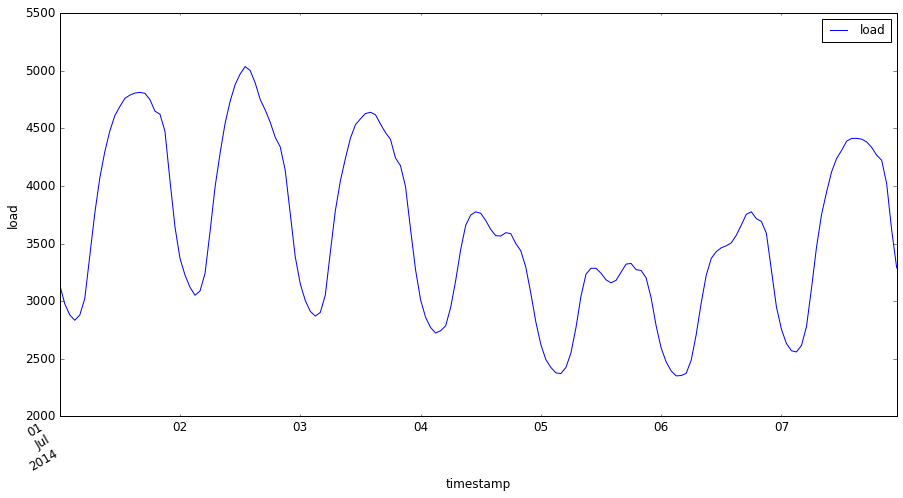

In [4]:
energy['2014-07-01':'2014-07-07'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [34]:
train_start_dt = '2014-01-01 00:00:00'

if(not demo):
    test_start_dt = '2014-11-01 00:00:00'
else: 
    test_start_dt = '2014-12-30 00:00:00'

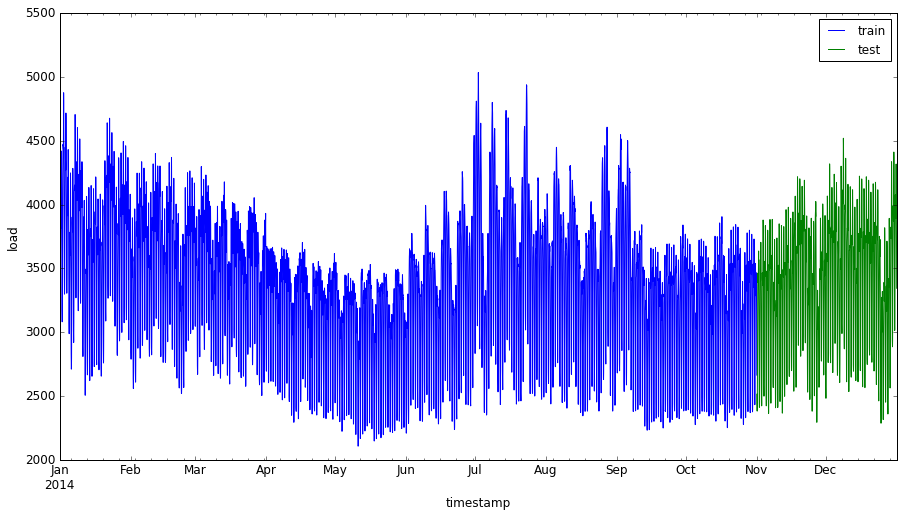

In [35]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Data preparation


Our data preparation for the training set will involve the following steps:

1. Filter the original dataset to include only that time period reserved for the training set
2. Scale the time series such that the values fall within the interval (0, 1)

Create training set containing only the model features

In [36]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print(train.shape)
print(test.shape)

(7296, 1)
(1464, 1)


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [37]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2014-01-01 00:00:00,0.41
2014-01-01 01:00:00,0.36
2014-01-01 02:00:00,0.33
2014-01-01 03:00:00,0.32
2014-01-01 04:00:00,0.33
2014-01-01 05:00:00,0.36
2014-01-01 06:00:00,0.41
2014-01-01 07:00:00,0.45
2014-01-01 08:00:00,0.51
2014-01-01 09:00:00,0.57


Original vs scaled data:

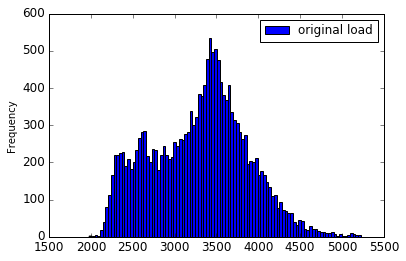

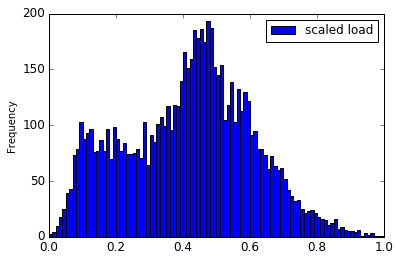

In [38]:
energy[energy.index < train_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

## Implement ARIMA method

An ARIMA model can be created using the statsmodels library. In the next section, we perform the following steps:
1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the forecast() function and specifying the number of steps (horizon) which to forecast

In [39]:
# Specify the number of steps to forecast ahead
HORIZON = 3 if demo else 24

Let’s look at an autocorrelation plot of the time series. The example below plots the autocorrelation for 48 lags in the time series.

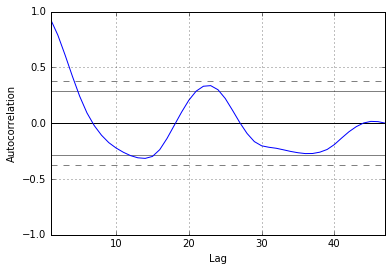

In [40]:
autocorrelation_plot(train[1:48])
plt.show()

We can see that there is a significant positive correlation with the first 5 lags or so. That may be a good starting point for the AR parameter (p) of the model.

The plot of energy load over time (see above) shows that the time series is not stationary due to its seasonality (daily peaks and also peaks in August and February due to the increased energy usage). This suggests the modeling might benefit from differencing the data, that is, making the data stationary. 
We show below what the data looks like when we difference the data by 24 hours.

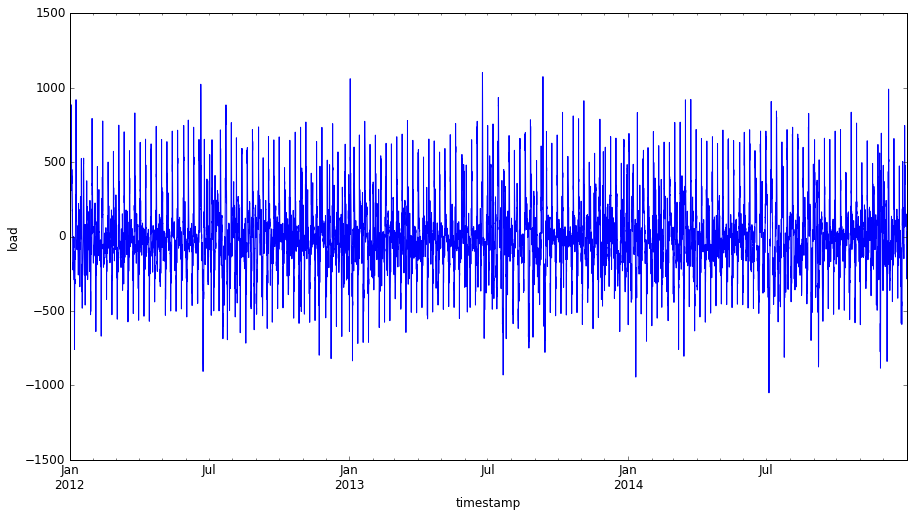

In [41]:
energy.copy()['load'].diff(periods=24).plot(y='load', figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Selecting the best parameters for an ARIMA model can be somewhat subjective and time intesive, so we'll leave it as an exercise to the user. We'll use a set of parameters we found work reasonably well through trial and error.

In [42]:
# fit model
model_params = (5,0,0)
model = ARIMA(train, order=model_params)
model_fit = model.fit(disp=0)
print(model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4154      0.006     72.489      0.000       0.404       0.427
ar.L1.load     2.2139      0.012    190.729      0.000       2.191       2.237
ar.L2.load    -1.9691      0.028    -70.829      0.000      -2.024      -1.915
ar.L3.load     1.0701      0.034     31.592      0.000       1.004       1.137
ar.L4.load    -0.4958      0.028    -17.833      0.000      -0.550      -0.441
ar.L5.load     0.1293      0.012     11.135      0.000       0.107       0.152


Next we display the distribution of residuals. A zero mean in the residuals show that there is no bias in the prediction. 

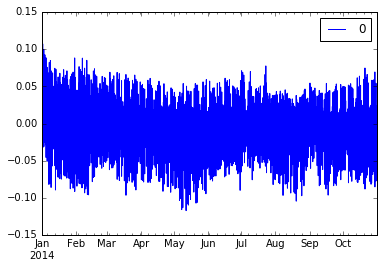

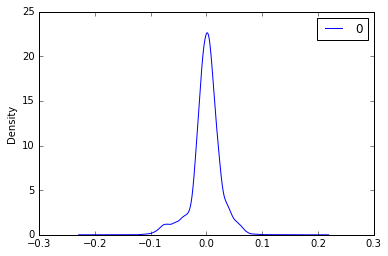

             0
count 7,296.00
mean     -0.00
std       0.03
min      -0.12
25%      -0.01
50%       0.00
75%       0.01
max       0.11


In [43]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Evaluate the model

We will perform the so-called walk forward validation. In practice, time series models are re-trained each time a new data becomes available. This allows the model to make the best forecast at each time step. 

Starting at the beginning of the time series, we train the model on the train data set. Then we make a prediction on the next time step. The prediction is then evaluated against the known value. The training set is then expanded to include the known value and the process is repeated. 

This process provides a more robust estimation of how the model will perform in practice. However, it comes at the computation cost of creating so many models. This is acceptable if the data is small or if the model is simple, but could be an issue at scale. 

Walk-forward validation is the gold standard of time series model evaluation and is recommended for your own projects.

Let us start by scaling the test data.

In [44]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-11-01 00:00:00,0.14
2014-11-01 01:00:00,0.11
2014-11-01 02:00:00,0.10
2014-11-01 03:00:00,0.09
2014-11-01 04:00:00,0.11


Create a test data point for each HORIZON step.

In [45]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3,load+4,load+5,load+6,load+7,load+8,load+9,...,load+14,load+15,load+16,load+17,load+18,load+19,load+20,load+21,load+22,load+23
2014-11-01 00:00:00,0.14,0.11,0.10,0.09,0.11,0.14,0.21,0.29,0.37,0.43,...,0.44,0.44,0.47,0.52,0.52,0.48,0.43,0.36,0.28,0.20
2014-11-01 01:00:00,0.11,0.10,0.09,0.11,0.14,0.21,0.29,0.37,0.43,0.45,...,0.44,0.47,0.52,0.52,0.48,0.43,0.36,0.28,0.20,0.16
2014-11-01 02:00:00,0.10,0.09,0.11,0.14,0.21,0.29,0.37,0.43,0.45,0.46,...,0.47,0.52,0.52,0.48,0.43,0.36,0.28,0.20,0.16,0.12
2014-11-01 03:00:00,0.09,0.11,0.14,0.21,0.29,0.37,0.43,0.45,0.46,0.45,...,0.52,0.52,0.48,0.43,0.36,0.28,0.20,0.16,0.12,0.10
2014-11-01 04:00:00,0.11,0.14,0.21,0.29,0.37,0.43,0.45,0.46,0.45,0.44,...,0.52,0.48,0.43,0.36,0.28,0.20,0.16,0.12,0.10,0.10


Make predictions on the test data

In [54]:
%%time

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
predictions = list()

model_params = (7,1,5)
for t in range(test_ts.shape[0]):
    model = ARIMA(history, order=model_params)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps = HORIZON)
    yhat = output[0]
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    history.append(obs[0])
    print(test_ts.index[t])
    #print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-11-01 00:00:00
2014-11-01 01:00:00
2014-11-01 02:00:00
2014-11-01 03:00:00
2014-11-01 04:00:00
2014-11-01 05:00:00
2014-11-01 06:00:00
2014-11-01 07:00:00
2014-11-01 08:00:00
2014-11-01 09:00:00
2014-11-01 10:00:00
2014-11-01 11:00:00
2014-11-01 12:00:00
2014-11-01 13:00:00
2014-11-01 14:00:00
2014-11-01 15:00:00
2014-11-01 16:00:00
2014-11-01 17:00:00
2014-11-01 18:00:00
2014-11-01 19:00:00
2014-11-01 20:00:00
2014-11-01 21:00:00
2014-11-01 22:00:00
2014-11-01 23:00:00
2014-11-02 00:00:00
2014-11-02 01:00:00
2014-11-02 02:00:00
2014-11-02 03:00:00
2014-11-02 04:00:00
2014-11-02 05:00:00
2014-11-02 06:00:00
2014-11-02 07:00:00
2014-11-02 08:00:00
2014-11-02 09:00:00
2014-11-02 10:00:00
2014-11-02 11:00:00
2014-11-02 12:00:00
2014-11-02 13:00:00
2014-11-02 14:00:00
2014-11-02 15:00:00
2014-11-02 16:00:00
2014-11-02 17:00:00
2014-11-02 18:00:00
2014-11-02 19:00:00
2014-11-02 20:00:00
2014-11-02 21:00:00
2014-11-02 22:00:00
2014-11-02 23:00:00
2014-11-03 00:00:00
2014-11-03 01:00:00


2014-11-18 02:00:00
2014-11-18 03:00:00
2014-11-18 04:00:00
2014-11-18 05:00:00
2014-11-18 06:00:00
2014-11-18 07:00:00
2014-11-18 08:00:00
2014-11-18 09:00:00
2014-11-18 10:00:00
2014-11-18 11:00:00
2014-11-18 12:00:00
2014-11-18 13:00:00
2014-11-18 14:00:00
2014-11-18 15:00:00
2014-11-18 16:00:00
2014-11-18 17:00:00
2014-11-18 18:00:00
2014-11-18 19:00:00
2014-11-18 20:00:00
2014-11-18 21:00:00
2014-11-18 22:00:00
2014-11-18 23:00:00
2014-11-19 00:00:00
2014-11-19 01:00:00
2014-11-19 02:00:00
2014-11-19 03:00:00
2014-11-19 04:00:00
2014-11-19 05:00:00
2014-11-19 06:00:00
2014-11-19 07:00:00
2014-11-19 08:00:00
2014-11-19 09:00:00
2014-11-19 10:00:00
2014-11-19 11:00:00
2014-11-19 12:00:00
2014-11-19 13:00:00
2014-11-19 14:00:00
2014-11-19 15:00:00
2014-11-19 16:00:00
2014-11-19 17:00:00
2014-11-19 18:00:00
2014-11-19 19:00:00
2014-11-19 20:00:00
2014-11-19 21:00:00
2014-11-19 22:00:00
2014-11-19 23:00:00
2014-11-20 00:00:00
2014-11-20 01:00:00
2014-11-20 02:00:00
2014-11-20 03:00:00


2014-12-05 04:00:00
2014-12-05 05:00:00
2014-12-05 06:00:00
2014-12-05 07:00:00
2014-12-05 08:00:00
2014-12-05 09:00:00
2014-12-05 10:00:00
2014-12-05 11:00:00
2014-12-05 12:00:00
2014-12-05 13:00:00
2014-12-05 14:00:00
2014-12-05 15:00:00
2014-12-05 16:00:00
2014-12-05 17:00:00
2014-12-05 18:00:00
2014-12-05 19:00:00
2014-12-05 20:00:00
2014-12-05 21:00:00
2014-12-05 22:00:00
2014-12-05 23:00:00
2014-12-06 00:00:00
2014-12-06 01:00:00
2014-12-06 02:00:00
2014-12-06 03:00:00
2014-12-06 04:00:00
2014-12-06 05:00:00
2014-12-06 06:00:00
2014-12-06 07:00:00
2014-12-06 08:00:00
2014-12-06 09:00:00
2014-12-06 10:00:00
2014-12-06 11:00:00
2014-12-06 12:00:00
2014-12-06 13:00:00
2014-12-06 14:00:00
2014-12-06 15:00:00
2014-12-06 16:00:00
2014-12-06 17:00:00
2014-12-06 18:00:00
2014-12-06 19:00:00
2014-12-06 20:00:00
2014-12-06 21:00:00
2014-12-06 22:00:00
2014-12-06 23:00:00
2014-12-07 00:00:00
2014-12-07 01:00:00
2014-12-07 02:00:00
2014-12-07 03:00:00
2014-12-07 04:00:00
2014-12-07 05:00:00


2014-12-22 06:00:00
2014-12-22 07:00:00
2014-12-22 08:00:00
2014-12-22 09:00:00
2014-12-22 10:00:00
2014-12-22 11:00:00
2014-12-22 12:00:00
2014-12-22 13:00:00
2014-12-22 14:00:00
2014-12-22 15:00:00
2014-12-22 16:00:00
2014-12-22 17:00:00
2014-12-22 18:00:00
2014-12-22 19:00:00
2014-12-22 20:00:00
2014-12-22 21:00:00
2014-12-22 22:00:00
2014-12-22 23:00:00
2014-12-23 00:00:00
2014-12-23 01:00:00
2014-12-23 02:00:00
2014-12-23 03:00:00
2014-12-23 04:00:00
2014-12-23 05:00:00
2014-12-23 06:00:00
2014-12-23 07:00:00
2014-12-23 08:00:00
2014-12-23 09:00:00
2014-12-23 10:00:00
2014-12-23 11:00:00
2014-12-23 12:00:00
2014-12-23 13:00:00
2014-12-23 14:00:00
2014-12-23 15:00:00
2014-12-23 16:00:00
2014-12-23 17:00:00
2014-12-23 18:00:00
2014-12-23 19:00:00
2014-12-23 20:00:00
2014-12-23 21:00:00
2014-12-23 22:00:00
2014-12-23 23:00:00
2014-12-24 00:00:00
2014-12-24 01:00:00
2014-12-24 02:00:00
2014-12-24 03:00:00
2014-12-24 04:00:00
2014-12-24 05:00:00
2014-12-24 06:00:00
2014-12-24 07:00:00


Compare predictions to actual load

In [55]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])

eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 00:00:00,t+1,"2,503.51","2,514.00"
1,2014-11-01 01:00:00,t+1,"2,436.79","2,434.00"
2,2014-11-01 02:00:00,t+1,"2,417.85","2,390.00"
3,2014-11-01 03:00:00,t+1,"2,388.12","2,382.00"
4,2014-11-01 04:00:00,t+1,"2,420.86","2,419.00"


Compute the mean absolute percentage error over all predictions

In [56]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1    0.02
t+10   0.19
t+11   0.19
t+12   0.19
t+13   0.18
t+14   0.17
t+15   0.17
t+16   0.17
t+17   0.16
t+18   0.16
t+19   0.15
t+2    0.04
t+20   0.14
t+21   0.13
t+22   0.12
t+23   0.11
t+24   0.10
t+3    0.07
t+4    0.10
t+5    0.13
t+6    0.15
t+7    0.17
t+8    0.18
t+9    0.19
Name: APE, dtype: float64


In [57]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  1.687743777515377 %


In [58]:
print('One step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

One step forecast MAPE:  14.120974761253871 %


Plot the predictions vs the actuals for the first week of the test set

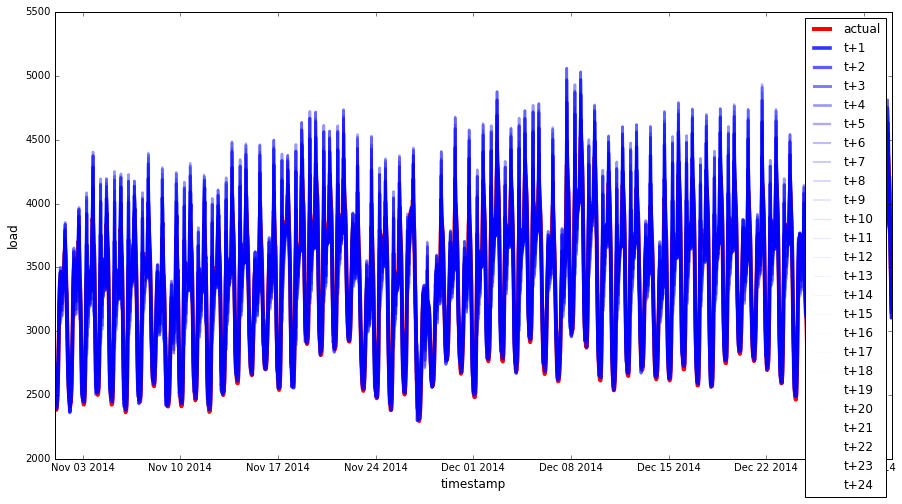

In [52]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        ax.plot(plot_df['timestamp'], plot_df['t+'+str(t)], color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()